In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_c

In [ ]:
!pip install tensorflow==2.15.0 tensorflow-addons==0.21.0

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import medmnist
from medmnist import INFO, Evaluator
import math
import numpy as np
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [2]:
print("Available datasets:")
print(list(medmnist.INFO.keys()))

Available datasets:
['pathmnist', 'chestmnist', 'dermamnist', 'octmnist', 'pneumoniamnist', 'retinamnist', 'breastmnist', 'bloodmnist', 'tissuemnist', 'organamnist', 'organcmnist', 'organsmnist', 'organmnist3d', 'nodulemnist3d', 'adrenalmnist3d', 'fracturemnist3d', 'vesselmnist3d', 'synapsemnist3d']


In [13]:

SEED = 42
keras.utils.set_random_seed(SEED)

# Constants
DATASET_NAME = 'breastmnist'
NUM_CLASSES = 2
INPUT_SHAPE = (28, 28, 1)

# Download and prepare the dataset
info = medmnist.INFO[DATASET_NAME]
data_path = keras.utils.get_file(origin=info["url"], md5_hash=info["MD5"])

with np.load(data_path) as data:
    # Get images
    train_image = data["train_images"]
    valid_image = data["val_images"]
    test_image = data["test_images"]

    # Get labels
    train_labels = data["train_labels"].flatten()
    valid_labels = data["val_labels"].flatten()
    test_labels = data["test_labels"].flatten()

# Print shapes of loaded data
print(f"x_train shape: {train_image.shape} - y_train shape: {train_labels.shape}")
print(f"x_valid shape: {valid_image.shape} - y_valid shape: {valid_labels.shape}")
print(f"x_test shape: {test_image.shape} - y_test shape: {test_labels.shape}")


x_train shape: (546, 28, 28) - y_train shape: (546,)
x_valid shape: (78, 28, 28) - y_valid shape: (78,)
x_test shape: (156, 28, 28) - y_test shape: (156,)


# **Configure the hyperparameters**

In [14]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

# **Use data augmentation**

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.03),
        layers.RandomZoom(height_factor=0.3, width_factor=0.3),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_image)

# **Implement Shifted Patch Tokenization**

In a ViT pipeline, the input images are divided into patches that are then linearly projected into tokens. Shifted patch tokenization (STP) is introduced to combat the low receptive field of ViTs. The steps for Shifted Patch Tokenization are as follows:



Start with an image.

Shift the image in diagonal directions.

Concat the diagonally shifted images with the original image.

Extract patches of the concatenated images.

Flatten the spatial dimension of all patches.

Layer normalize the flattened patches and then project it.

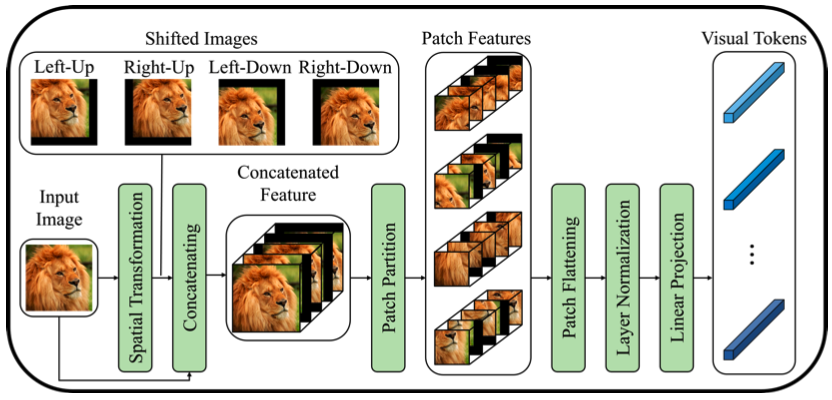

In [16]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

# **Implement the patch encoding layer**

This layer accepts projected patches and then adds positional information to them.

In [17]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

# **Implement Locality Self Attention**
The attention module takes a query, key, and value. First, we compute the similarity between the query and key via a dot product. Then, the result is scaled by the square root of the key dimension. The scaling prevents the softmax function from having an overly small gradient. Softmax is then applied to the scaled dot product to produce the attention weights. The value is then modulated via the attention weights.

In self-attention, query, key and value come from the same input. The dot product would result in large self-token relations rather than inter-token relations. This also means that the softmax gives higher probabilities to self-token relations than the inter-token relations. To combat this, the authors propose masking the diagonal of the dot product. This way, we force the attention module to pay more attention to the inter-token relations.

The scaling factor is a constant in the regular attention module. This acts like a temperature term that can modulate the softmax function. The authors suggest a learnable temperature term instead of a constant.

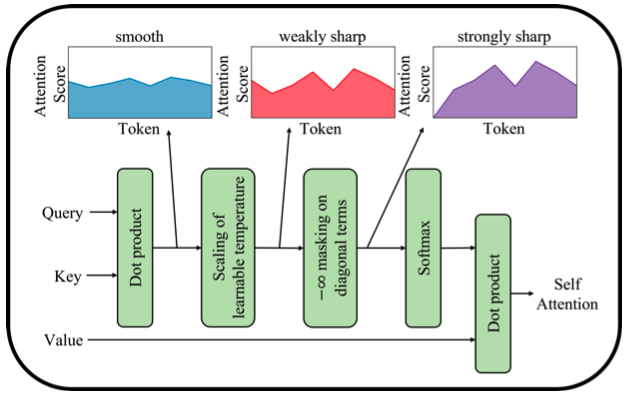

The above two pointers make the Locality Self Attention. We have subclassed the layers.MultiHeadAttention and implemented the trainable temperature. The attention mask is built at a later stage.

In [18]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

***Implement the MLP***

In [19]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

# **Build the ViT**

In [20]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# **Compile, train, and evaluate the mode**

Epoch 1/50
2/2 [==============================] - 13s 2s/step - loss: 12.2406 - accuracy: 0.5723 - top-5-accuracy: 1.0000 - val_loss: 0.7576 - val_accuracy: 0.7636 - val_top-5-accuracy: 1.0000
Epoch 2/50
2/2 [==============================] - 1s 399ms/step - loss: 2.9645 - accuracy: 0.5458 - top-5-accuracy: 1.0000 - val_loss: 2.0222 - val_accuracy: 0.7636 - val_top-5-accuracy: 1.0000
Epoch 3/50
2/2 [==============================] - 1s 428ms/step - loss: 2.1836 - accuracy: 0.7312 - top-5-accuracy: 1.0000 - val_loss: 1.3259 - val_accuracy: 0.4182 - val_top-5-accuracy: 1.0000
Epoch 4/50
2/2 [==============================] - 1s 397ms/step - loss: 1.0852 - accuracy: 0.5743 - top-5-accuracy: 1.0000 - val_loss: 0.4919 - val_accuracy: 0.7636 - val_top-5-accuracy: 1.0000
Epoch 5/50
2/2 [==============================] - 1s 398ms/step - loss: 0.8928 - accuracy: 0.6986 - top-5-accuracy: 1.0000 - val_loss: 0.4866 - val_accuracy: 0.7636 - val_top-5-accuracy: 1.0000
Epoch 6/50
2/2 [===============

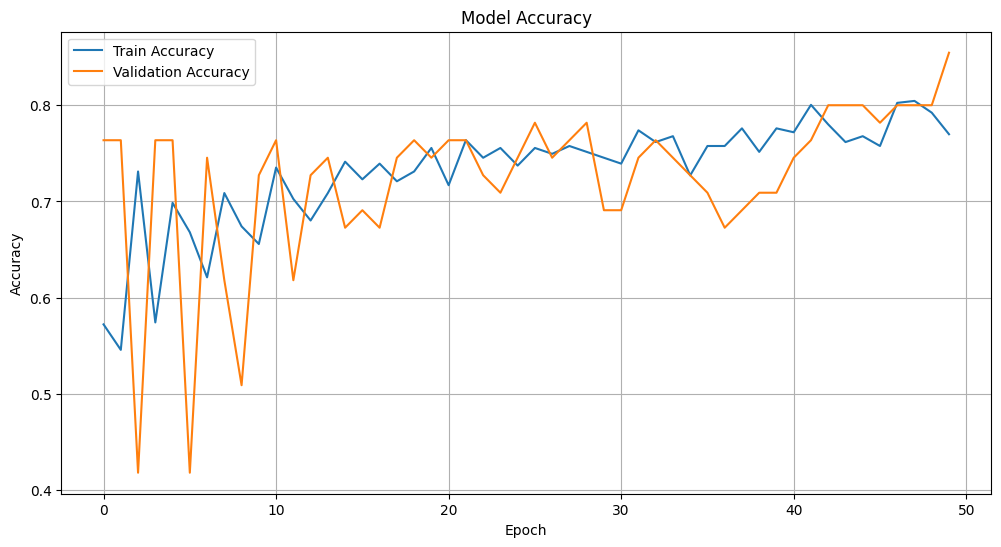

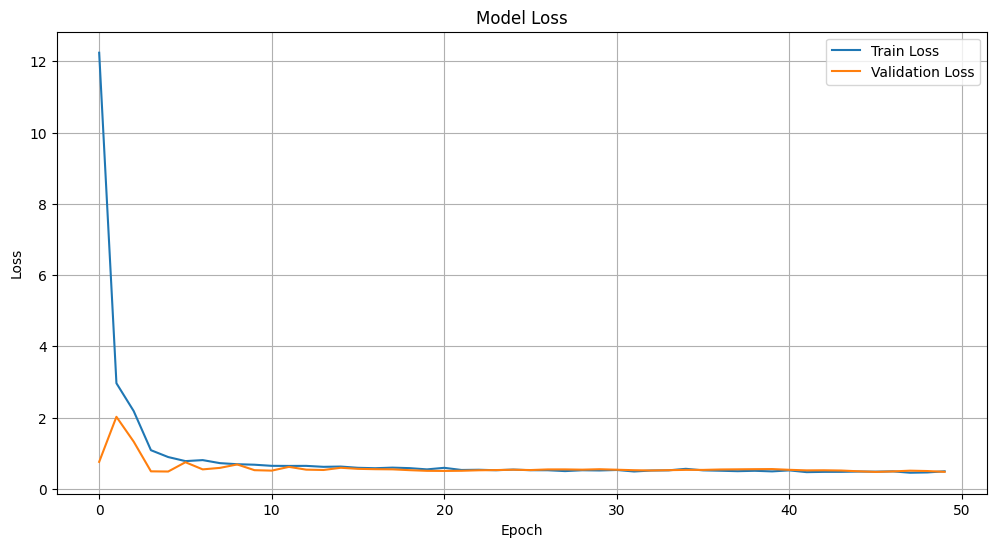

5/5 [==============================] - 1s 31ms/step


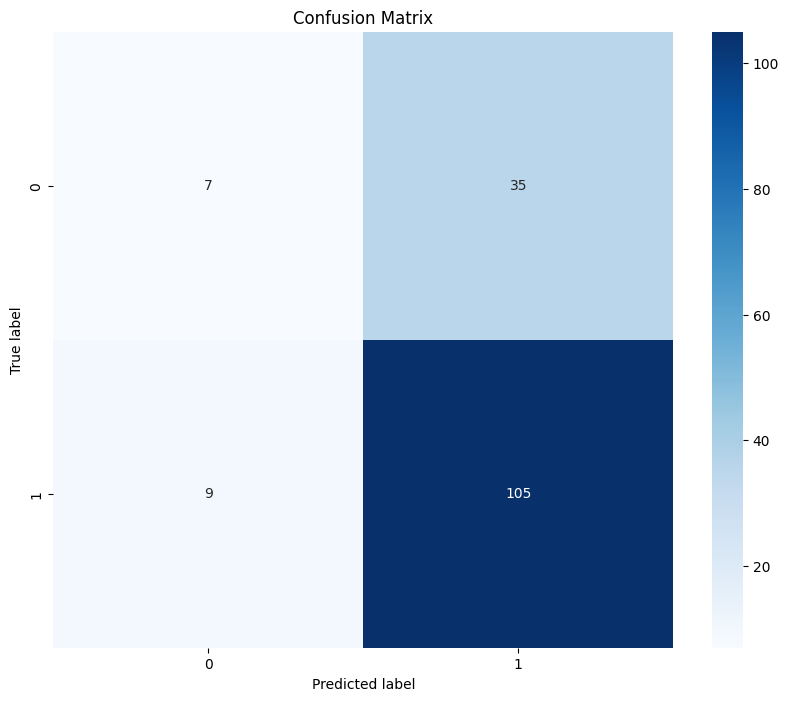

Epoch 1/50
2/2 [==============================] - 14s 2s/step - loss: 8.4732 - accuracy: 0.5438 - top-5-accuracy: 1.0000 - val_loss: 0.7416 - val_accuracy: 0.7636 - val_top-5-accuracy: 1.0000
Epoch 2/50
2/2 [==============================] - 1s 603ms/step - loss: 2.3096 - accuracy: 0.6171 - top-5-accuracy: 1.0000 - val_loss: 0.7994 - val_accuracy: 0.7636 - val_top-5-accuracy: 1.0000
Epoch 3/50
2/2 [==============================] - 1s 623ms/step - loss: 1.4423 - accuracy: 0.7332 - top-5-accuracy: 1.0000 - val_loss: 2.5025 - val_accuracy: 0.3273 - val_top-5-accuracy: 1.0000
Epoch 4/50
2/2 [==============================] - 1s 628ms/step - loss: 1.3599 - accuracy: 0.5662 - top-5-accuracy: 1.0000 - val_loss: 0.5243 - val_accuracy: 0.7818 - val_top-5-accuracy: 1.0000
Epoch 5/50
2/2 [==============================] - 1s 642ms/step - loss: 1.0767 - accuracy: 0.7251 - top-5-accuracy: 1.0000 - val_loss: 0.4585 - val_accuracy: 0.8364 - val_top-5-accuracy: 1.0000
Epoch 6/50
2/2 [================

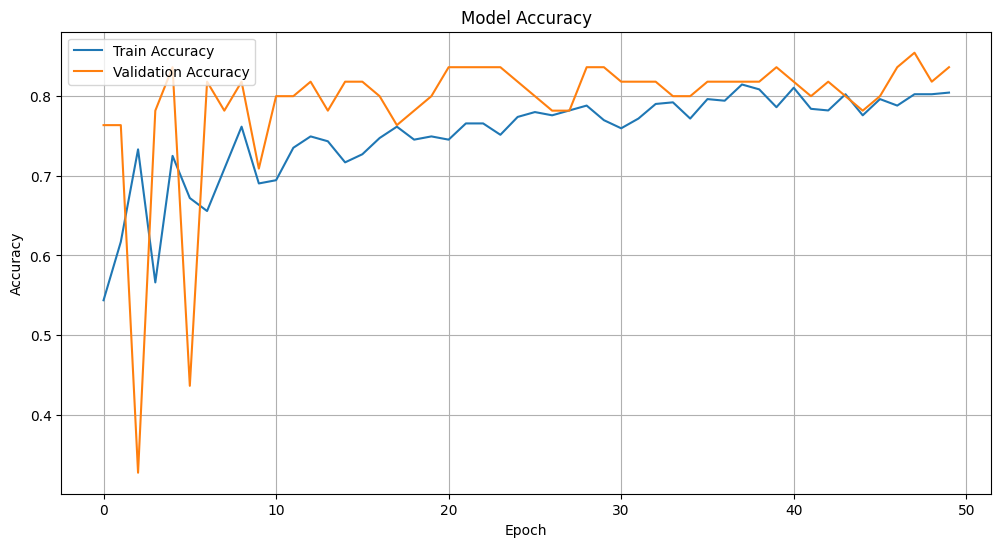

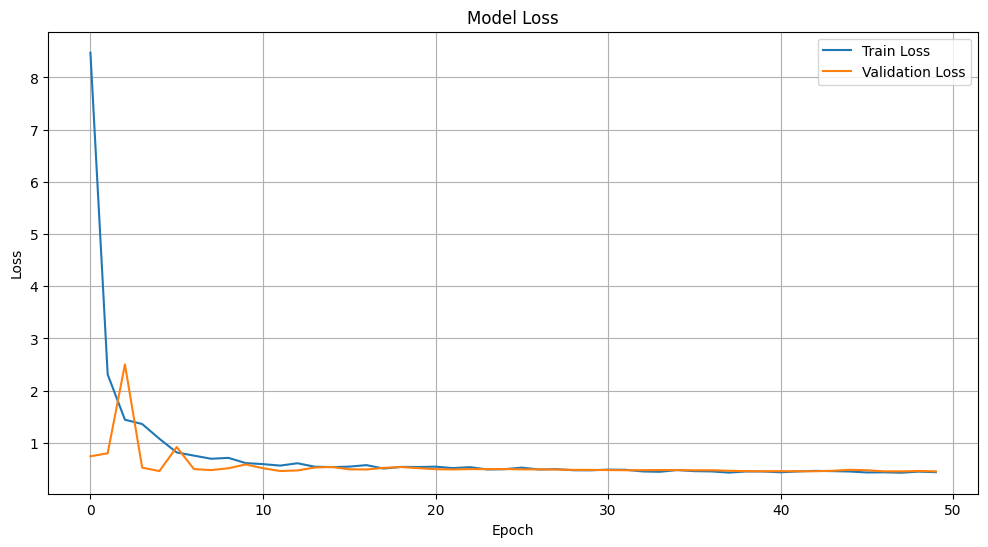

5/5 [==============================] - 1s 45ms/step


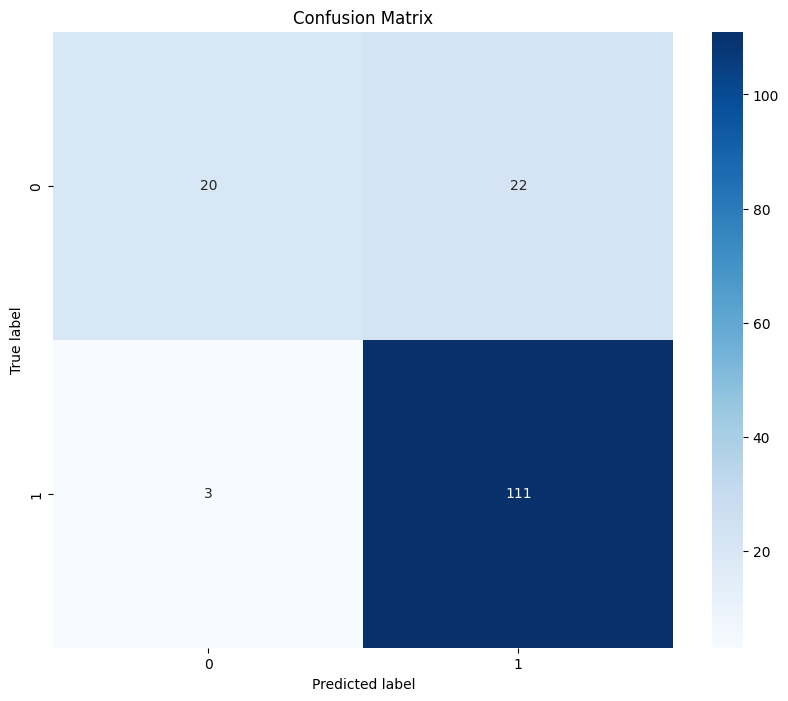

In [21]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(train_image) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=train_image,
        y=train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )
    _, accuracy, top_5_accuracy = model.evaluate(test_image, test_labels, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_accuracy(history):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

def plot_loss(history):
    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

def plot_confusion_matrix(model, x_test, y_test):
    # Predict classes
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Display confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Run experiments with the vanilla ViT and plot the results
vit = create_vit_classifier(vanilla=True)
history_vit = run_experiment(vit)

# Plot accuracy and loss for the vanilla ViT
plot_accuracy(history_vit)
plot_loss(history_vit)
plot_confusion_matrix(vit, test_image, test_labels)

# Run experiments with the Shifted Patch Tokenization and Locality Self Attention modified ViT
vit_sl = create_vit_classifier(vanilla=False)
history_vit_sl = run_experiment(vit_sl)

# Plot accuracy and loss for the modified ViT
plot_accuracy(history_vit_sl)
plot_loss(history_vit_sl)
plot_confusion_matrix(vit_sl, test_image, test_labels)